## Methods for the SOAR Exposure Time Calculator
**Author:** [F. Navarete](https://github.com/navarete) [felipe.navarete at noirlab.edu] \
**Date:** Dec 26, 2022

This notebook presents the general formulae for computing the expected exposure time for observations taken with an optical telescope.
Specifications can be done for the telescope and the cameras.
---
To plot the results, simply run: <br>
`etc_imaging(mag=mag, exposure=exposure, seeing=seeing, airmass=airmass, filter_name=filter_name, instrument=instrument, debug=False)`

where:
- **mag** *(float, default=10)*: magnitude of the source (in the Vega system)
- **exposure** *(float, default=100)*: exposure time (in seconds)
- **seeing** *(float, default=1.0)*: atmospheric seeing (in arcseconds)
- **airmass** *(float, default=1.0)*: airmass of the observations (>1.0)
- **filter_name** *(str, default="K")*: name of the filter (available now: Y, J, H , K) 
- **instrument** *(str, default="Spartan")*: name of the instrument (Available now: Spartan)
- **debug** *(bool, default=False)*
---
**Requirements:**
- Astropy
- Matplotlib
- Numpy
---
**History:**
- v1.0 (Jun 22, 2022): Add functions from http://www.eso.org/observing/etc/doc/formulabook/index.html \
- v1.1 (Jul 15, 2022): Tidy up and organize formulae \
- v1.2 (Aug 30, 2022): Include airmass calculation, add DEBUG option for developers, add new Spartan filters for testing
- v1.3 (Dec 26, 2022): Include visualization output, flag saturated pixels as red.

In [46]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import units as u #units
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
print("Imports are done.")

Imports are done.


In [112]:
def filter_specs(filter_name, instrument, micron=True):
    """
        Given a 'filter name' and 'instrument',
        returns the central wavelength, width and zero-point of the filter.

        For now, tests are done with Spartan and the broad-band filters (Y, J, H and K) only.
    """
    
    # filter info: # http://svo2.cab.inta-csic.es/theory/fps/index.php?id=CTIO/Spartan.J&&mode=search&search_text=spartan#filter
    
    print("[TBD] read the file with the filter transmission and extract the proper information, or set a JSON file with all the info.")
    #infolder_filters = 'D:/SOAR/ETC/filter_transmission/'
    #data = ascii.read(infolder_filters + 'SOAR_' + instrument + '.' + filter_name + '.dat')
    #wave  = data['col1']
    #trans = data['col2']
    # compute the filter width using the CDF
    #cdf_filter = trans * 0.0
    #for n in range(0,len(trans)):
    #    cdf_filter[n] = sum(trans[0:n])/sum(trans)
    # assume a gaussian 1-sigma (68%) to estimate the filter width
    #pwmin = 0.50-0.68/2
    #pwmax = 0.50+0.68/2
    #i_wmin = abs( cdf_filter - np.quantile(cdf_filter,pwmin,interpolation='nearest') ).argmin()
    #i_wmax = abs( cdf_filter - np.quantile(cdf_filter,pwmax,interpolation='nearest') ).argmin()
    #filter_width = abs( wave[i_wmax] - wave[i_wmin] )
    #print(filter_width)
    #pmin = 0.50-0.9/2
    #pmax = 0.50+0.9/2
    #i_min = abs( cdf_filter - np.quantile(cdf_filter,pmin,interpolation='nearest') ).argmin()
    #i_max = abs( cdf_filter - np.quantile(cdf_filter,pmax,interpolation='nearest') ).argmin()
    #print( wave[i_max], wave[i_min] )
    #wave_eff = sum( wave * trans ) / sum( trans )
    #print("------------------------------")    
    
    #filter characteristics
    if filter_name == 'Y':
        filter_specs = [ 10171.32 * u.angstrom, # central wave
                          9549.20 * u.angstrom, # min wave
                         10826.20 * u.angstrom, # max wave
                           997.50 * u.angstrom, # width
                         6.02954e-10 * u.erg / u.second / u.centimeter / u.centimeter / u.angstrom # flux zero-point
                       ]
    if filter_name == 'J':
        filter_specs = [ 12272.76 * u.angstrom, # central wave
                         11201.86 * u.angstrom, # min wave
                         13552.61 * u.angstrom, # max wave
                          1856.30 * u.angstrom, # width
                         3.11372e-10 * u.erg / u.second / u.centimeter / u.centimeter / u.angstrom # flux zero-point
                       ]
    if filter_name == 'H':
        filter_specs = [ 16171.47 * u.angstrom,
                         14656.73 * u.angstrom,
                         18059.17 * u.angstrom,
                          2861.33 * u.angstrom,
                         1.17623E-10 * u.erg / u.second / u.centimeter / u.centimeter / u.angstrom,
                       ]
    if filter_name == 'K':
        filter_specs = [ 21498.85 * u.angstrom,
                         19626.93 * u.angstrom,
                         23448.35 * u.angstrom,
                          2967.97 * u.angstrom,
                         4.35E-10 * u.watt / u.meter / u.meter / u.micron,
                       ]
    
    filter_wave            = filter_specs[0]
    wave_min               = filter_specs[1]
    wave_max               = filter_specs[2]
    filter_width           = filter_specs[3]
    zero_point             = filter_specs[4]
    if micron is True:
        filter_wave  = filter_wave.to(u.micron)
        filter_width = filter_width.to(u.micron)
    
    return filter_wave, filter_width, wave_min, wave_max, zero_point

################################################################################
def instrument_specs(instrument):
    """
        Returns the instrument specifications
    """
    if instrument == 'Spartan':
        pixel_scale  = 0.067 * u.arcsec
        gain         = 4.60 # e-/ADU
        readnoise    = 16.0 # e-
        saturation   = 26000 # adu
        dark_current =  0.333 * ( 1 / u.second ) # adu / sec, empirical data from Jun 2022
        min_exposure = 10 * u.second
        
    print('[TBD] Need to place input values for instrument_specs()')
    return pixel_scale, readnoise, saturation * gain, dark_current, gain, min_exposure

################################################################################
def telescope_specs(wave):
    """
        Returns the properties of the SOAR telescope
    """
    tel_diameter = 4.1 * u.meter
    central_obscuration_diameter = 0.9365 * u.meter
    tel_surface = np.pi * ( ( tel_diameter *0.5)**2 -( central_obscuration_diameter *0.5)**2 ) # in m2
    efficiency = 1.0 # should be a function of the wavelength
    print('[TBD] Need proper input values for efficiency parameter in telescope_specs()')
    return tel_surface, efficiency

def area_seeing(seeing, pixel_scale=False):
    """ Computes the area on sky for a point source. If pixel_scale is provided, returns the value in pixels."""
    ps_area = np.pi * ( seeing )**2
    if pixel_scale is not False:
        ps_area /= (pixel_scale )**2

    return ps_area

################################################################################
def mag_to_flux(mag, filter_name, instrument):
    """
        Converts magnitudes in the Vega system to flux in W/m2/micron units
        source: https://www.gemini.edu/observing/resources/magnitudes-and-fluxes
    """
    
    #  returns the central wavelength and width of the filter
    #filter_wavec, filter_width, wave_min, wave_max, zero_point = filter_specs(filter_name, instrument)
    #print('filter_wavec:', filter_wavec)
    
    #if filter_name == 'K':
    #f0 = 4.57E-10 * ( u.watt / u.meter / u.meter / u.micron ) # in W/m2/micron
    
    filter_wavec, x, x, x, zero_point = filter_specs(filter_name, instrument)
    
    flux = zero_point * 10 ** (-mag/2.5)

    # add an IF erg is set, then:
    flux = flux.to(u.erg / u.second / u.meter / u.meter / u.micron)
    
    return flux

################################################################################
def photon_energy(wave):
    """
        Returns the energy of the photon at a given wavelength in e-
    """
    h = 6.626e-27 * ( u.erg * u.second )
    c = 2.998e10  * ( u.cm  / u.second )
    ph_energy = h * c / wave.to(u.cm) # in erg
    return ph_energy

################################################################################
def sky_emission(filter_name, instrument, bright=False):
    """
        Returns the sky background emission at a given filter/wavelength and exposure time.
        Should be wavelength and moon_phase specific
    """
    sky_mag = np.nan
    
    # http://www.ctio.noirlab.edu/noao/sites/default/files/Night%20Sky%20Brightness%20at%20Cerro%20Pachon.pdf
    if filter_name == 'U': sky_mag = 22.08 # mag/arcsec2
    if filter_name == 'B': sky_mag = 22.81 # mag/arcsec2
    if filter_name == 'V': sky_mag = 21.79 # mag/arcsec2
    if filter_name == 'R': sky_mag = 21.19 # mag/arcsec2
    if filter_name == 'I': sky_mag = 19.85 # mag/arcsec2
        
    # http://www.gemini.edu/observing/telescopes-and-sites/sites
    if bright is True:
        if filter_name == 'U': sky_mag = 15.0 # mag/arcsec2
        if filter_name == 'B': sky_mag = 17.5 # mag/arcsec2
        if filter_name == 'V': sky_mag = 18.0 # mag/arcsec2
        if filter_name == 'R': sky_mag = 17.9 # mag/arcsec2
        if filter_name == 'I': sky_mag = 18   # mag/arcsec2
        
    # http://www.gemini.edu/observing/telescopes-and-sites/sites
    if filter_name == 'Y': sky_mag = 17.2 # mag/arcsec2 - http://www.gemini.edu/sciops/instruments/gmos/AirglowSPIE_moon.pdf
    if filter_name == 'J': sky_mag = 16.2 # mag/arcsec2
    if filter_name == 'H': sky_mag = 13.8 # mag/arcsec2
    if filter_name == 'K': sky_mag = 14.6 # mag/arcsec2
    
    # older values from NOAO Newsletter #10 are given in http://astroweb.case.edu/ssm/ASTR620/mags.html
    
    if sky_mag == np.nan: print('No sky emission info available for this filter.')
    
    sky_flux = mag_to_flux(sky_mag, filter_name, instrument) / ( u.arcsec )**2
    
    return sky_flux


################################################################################
def airmass_extinction(flux, wave, airmass=1.0, mag_correction=True):
    """
      Apply airmass correction on the flux.
      'extinction_coefficient' is wavelength-dependent
      data from 'Sky Transparency/Extinction' (http://www.gemini.edu/observing/telescopes-and-sites/sites)
    """
    
    # wavelength in nm, extinction coefficients from http://www.gemini.edu/observing/telescopes-and-sites/sites
    wave_coeff_nm = [  310,  320,  340,  360,  380,  400,  450,  500,  550,  600,  650,  700,  800,  900,  1250,   1650,  2200 ]
    ext_coeff     = [ 1.37, 0.82, 0.51, 0.37, 0.30, 0.25, 0.17, 0.13, 0.12, 0.11, 0.11, 0.10, 0.07, 0.05, 0.015 , 0.015, 0.033 ]
    
    #simply get the closest value from 'wave_coeff_nm' and assume as the extinction coefficient for the filter centered at 'wave_nm'
    wave_nm = wave.to(u.nm).value
    i = (np.abs(wave_coeff_nm - wave_nm)).argmin()
    extinction_coefficient = ext_coeff[i]
    
    # apply airmass correction
    if mag_correction:
        mag_cor = flux + extinction_coefficient * airmass
        return mag_cor
    else:
        ext_airmass = np.exp( -extinction_coefficient * airmass )
        flux_cor = flux * ext_airmass
        return flux_cor


################################################################################
def model_psf(fwhm=1.0, pixel_scale=0.067, peak_flux=30000, saturation=60000, bias_value=0, plot_psf=True):
    """Create a model for a 2-d PSF function using size = FWHM * 5 and
       reevaluate the total flux based on the peak flux and the saturation threshould
       
        Parameters
        ----------
        fwhm: float
            FWHM of the PSF (arcseconds)
        pixel_scale: float
            pixel scale of the instrument (in arcseconds/pixel)
        peak_flux: float
            peak flux of the object not considering the sky contribution (in ADU) 
        saturation: float
            saturation limit of the instrument (in ADU)
        bias_value: float
            add a fixed value for the bias (e.g. sky contribution, in ADU/pixel)
        plot_psf: Boolean
            plot the 2d PSF model after computing the flux lost due to saturation (True/False)
        Returns
        ----------
        ratio_saturation: float
            ratio between the total flux of the saturated psf and the original psf.
    
    """
    
    radius_psf = 2.5 * fwhm # should be in arcseconds
    n_pixel = int(np.round(2*radius_psf / pixel_scale)) # number of pixels for the entire PSF model
    #print('n_pixel=',n_pixel)
    
    #  make (x,y) array
    x = np.linspace(-radius_psf, radius_psf, num=n_pixel)
    y = x
    x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
    
    #  definitions for the Gaussian model
    center_x = 0 # will be centered at x=0
    center_y = 0 # will be centered at y=0
    sigma_x = fwhm / 2.355 # FWHM = 2.355 * sigma_gauss
    sigma_y = fwhm / 2.355 # FWHM = 2.355 * sigma_gauss
    #  calculate the Gaussian model
    gauss2d = 1. / (2. * np.pi * sigma_x * sigma_y) * np.exp(-((x - center_x)**2. / (2. * sigma_x**2.) + (y - center_y)**2. / (2. * sigma_y**2.)))

    #  now, use the provided peak flux and obtain the total flux of the PSF
    gauss2d *= peak_flux / np.max(gauss2d)
    
    #gauss2d_sky = gauss2d + bias_value
    
    total_flux = np.sum(gauss2d)
    #print('total_flux=',total_flux)
    
    # truncate the PSF using the saturation limit and obtain the total flux of the saturated PSF
    gauss2d_sat = gauss2d
    gauss2d_sat[gauss2d > ( saturation - bias_value )] = saturation
    sat_flux = np.sum(gauss2d_sat)
    
    gauss2d_sat += bias_value
    #print('sat_flux=',sat_flux)
    
    #  calculate the ratio between the total flux of the saturated PSF and the original one
    #  (this is how much flux you are actually measuring on your CCD)
    ratio_sat = sat_flux/total_flux
    print_contour=False
    if ratio_sat < 1.0:
        print('(WARNING) Your source will be saturated (red pixels).')
    #    #print('Your source is saturated!')
    #    print_contour=True
    #print('sat_flux/total_flux=',ratio_sat)
    
    #  display the 2d PSF on screen (values are shown from 0 to saturation limit)
    if plot_psf:
        print('')
        print('Gaussian PSF model (Source + Sky)')
        print('Contours are placed at the 50% (dashed line) and 99% of the saturation limit (solid)')
        extent = [np.min(x),np.max(x),np.min(y),np.max(y)]
        # define colormap to show the output
        cmap = 'gnuplot2'
        # add red to the top of the colorbar
        cmap_sat0 = plt.colormaps[cmap]
        newcolors = cmap_sat0(np.linspace(0,1,256))
        set_red = np.array([1,0,0,1])
        newcolors[-1:,:] = set_red
        cmap_sat = ListedColormap(newcolors)
        
        #plt.imshow(gauss2d_sat, interpolation='none', vmin=0, vmax=saturation, cmap=cmap, extent=extent)
        plt.imshow(gauss2d_sat, interpolation='none', vmin=0, vmax=saturation, cmap=cmap_sat, extent=extent)
        
        plt.colorbar(label='Flux (ADU)')
        
        #if print_contour:
        
        cont = plt.contour(gauss2d_sat, levels=[saturation*0.50,saturation*0.99],
                    colors=['black','black'], linestyles=['dashed','solid'], origin='image', extent=extent)#,
                   #label=['50% saturation','100% saturation'])
        
        #plt.clabel(cont, inline=1, fontsize=10)
            #plt.contour(gauss2d_sat, levels=[saturation*0.99], colors='black', linestyles='solid', origin='image', extent=extent)
        #plt.legend() 
        plt.xlabel('X axis (arcsec)')
        plt.ylabel('Y axis (arcsec)')
        plt.show()
    
    return ratio_sat

################################################################################
#############################                  #################################
#############################   ETC MAIN CODE  #################################
#############################                  #################################
################################################################################
def etc_imaging(mag,
                exposure=100,
                seeing  =1.0,
                airmass =1.0,
                filter_name="K",
                instrument ="Spartan",
                debug=False):

    ####################################### INSTRUMENT
    #  filter_specs() - returns specifications of the filter
    filter_wavec, filter_width, wave_min, wave_max, zero_point = filter_specs(filter_name, instrument)
    #print('filter_wavec, filter_width, zero_point:', filter_wavec, filter_width, zero_point)

    # instrument_specs() - return specifications of the instrument
    pixel_scale, readnoise, saturation, dark_current, gain, min_exposure = instrument_specs(instrument)
    
    # if the requested exposure time is shorter than the minimum exposure time, replace it:
    exposure = exposure * u.second
    if exposure.value < min_exposure.value:
        print('(WARNING) Requested exposure time is shorter than the instrument minimum exposure time.')
        exposure = min_exposure
    
    if debug:
        print('  <DEBUG> pixel_scale=',pixel_scale)
        print('  <DEBUG> readnoise=',readnoise)
        print('  <DEBUG> saturation=',saturation)
        print('  <DEBUG> dark_current=',dark_current)

    #  telescope_specs() - returns specifications of the telescope
    tel_surface, tel_efficiency = telescope_specs(filter_wavec)
    
    if debug:
        print('  <DEBUG> tel_surface, tel_efficiency:', tel_surface, tel_efficiency)

    ####################################### CONDITIONS

    #  area_seeing() - returns area of the PSF on sky (in arcsec2) and on the CCD (in pixels)
    seeing = seeing * u.arcsec
    area_arcsec = area_seeing(seeing)
    area_pixel  = area_seeing(seeing,pixel_scale)
    
    if debug:
        print('  <DEBUG> seeing,area_arcsec,area_pixel=',seeing,',',area_arcsec,',',area_pixel)

    ####################################### SOURCE

    #  photon_energy() - compute the photon energy for the central wavelength of the filter - in erg/photon
    ph_energy = photon_energy(filter_wavec)
    
    if debug:
        print('  <DEBUG> ph_energy:', ph_energy)

    #  apply airmass extinction on input magnitude
    mag_ground = airmass_extinction(mag, filter_wavec, airmass=airmass, mag_correction=True)
        
    flux_obj = mag_to_flux(mag_ground, filter_name, instrument)
    
    if debug:
        print('  <DEBUG> flux_obj:', flux_obj)

    flux_sky = sky_emission(filter_name, instrument)
    if debug:
        print('  <DEBUG> flux_sky=',flux_sky)

    ####################################### ETC calculations
    #  first, obtain the total flux of a point-source -> it should be given in number of photons detected by the CCD
    counts_object = ( flux_obj / ph_energy * filter_width ) * exposure * ( tel_surface * tel_efficiency )
    
    #  now, assume a gaussian shape for the PSF and estimate the peak intensity of the point-source
    peak_object = counts_object / ( seeing / pixel_scale ) / 1.0645

    if debug:
        print('  <DEBUG> counts_object=',counts_object)
        print('  <DEBUG> peak_object=  ',peak_object)

    #  now, obtain the sky counts per pixel
    counts_sky_per_pixel = ( flux_sky / ph_energy * filter_width ) * exposure * ( tel_surface * tel_efficiency ) * pixel_scale**2 # per pixel

    #  use the area of the PSF on the detector to estimate the total counts of the sky over the source
    counts_sky = counts_sky_per_pixel * area_pixel
    
    if debug:
        print('  <DEBUG> counts_sky_per_pixel=',counts_sky_per_pixel)
        print('  <DEBUG> counts_sky=',counts_sky)

    #  Use the sky + peak to check if the source will saturate the detector or not
    peak_max = counts_sky_per_pixel + peak_object
    ratio_peak = 1.0 # peak ratio for non-saturated sources
    stat_sat = 'No'
    
    if debug:
        print('  <DEBUG> sky+peak_object',peak_max)
    
    # print the model of the PSF and check for saturation
    ratio_satcounts = model_psf(fwhm=seeing.value,pixel_scale=pixel_scale.value, peak_flux=peak_object.value/gain,
                                saturation=saturation/gain, bias_value=counts_sky_per_pixel.value/gain, plot_psf=True)
    
    if peak_max > saturation:
        stat_sat = 'Yes'
        ratio_peak = saturation / peak_max
        
    # reevaluate the counts considering saturation of the detector
    counts_object *= ratio_satcounts
    peak_max *= ratio_peak

    # calculate the total noise on source, using the counts of the object and the sky, the dark current and the detector readnoise 
    noise = ( counts_object + counts_sky + ( area_pixel * dark_current * exposure ) + area_pixel * readnoise**2 )**0.5

    # now obtain the noise at the peak 
    noise_peak = ( peak_object + counts_sky_per_pixel + ( dark_current * exposure ) + readnoise**2 )**0.5

    noise_sky  = ( counts_sky_per_pixel + ( dark_current * exposure ) + readnoise**2 )**0.5

    if debug:
        print('  <DEBUG> noise=',noise)

    snr_obj = counts_object / noise
    snr_peak = peak_object / noise_peak
    
    if debug:
        print('  <DEBUG> SNR=',snr_obj)
        print('  <DEBUG> SNRpeak=',snr_peak)

    
    print('')
    print('-----------')
    print('ETC results')
    print('-----------')
    print('Inputs:')
    print('  Exposure:  ', exposure)
    print('  Seeing:    ', seeing)
    print('  Magnitude: ', mag)
    print('  Airmass:   ', airmass)
    print('  Instrument:', instrument)
    print('  Filter:    ', filter_name)
    print('-----------')
    print('Outputs:')
    print('  Saturated?                   ', stat_sat)
    print('  Saturation (ADU):        {:8.2f}'.format(saturation/gain) )
    print('  Dark counts (ADU/pixel): {:8.2f}'.format(dark_current * exposure) )
    print('  Sky counts (ADU/pixel):  {:8.2f}'.format(counts_sky_per_pixel/gain) )
    print('  Noise (ADU/pixel):       {:8.2f}'.format(noise/gain) )
    print('  Peak intensity (ADU):    {:8.2f}'.format(peak_max/gain) )
    print('  SNRpeak:                 {:8.2f}'.format(snr_peak) )
    print('  SNRtotal:                {:8.2f}'.format(snr_obj) )
    print('-----------')

print('Definitions were loaded')


Definitions were loaded


[TBD] read the file with the filter transmission and extract the proper information, or set a JSON file with all the info.
[TBD] Need to place input values for instrument_specs()
[TBD] Need proper input values for efficiency parameter in telescope_specs()
[TBD] read the file with the filter transmission and extract the proper information, or set a JSON file with all the info.
[TBD] read the file with the filter transmission and extract the proper information, or set a JSON file with all the info.
(WARNING) Your source will be saturated (red pixels).

Gaussian PSF model (Source + Sky)
Contours are placed at the 50% (dashed line) and 99% of the saturation limit (solid)


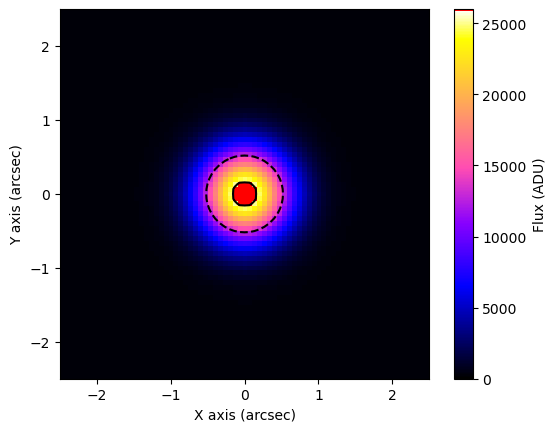


-----------
ETC results
-----------
Inputs:
  Exposure:   10.0 s
  Seeing:     1.0 arcsec
  Magnitude:  12.3
  Airmass:    1.5
  Instrument: Spartan
  Filter:     K
-----------
Outputs:
  Saturated?                    Yes
  Saturation (ADU):        26000.00
  Dark counts (ADU/pixel):     3.33
  Sky counts (ADU/pixel):    246.64
  Noise (ADU/pixel):         375.38
  Peak intensity (ADU):    26000.00
  SNRpeak:                   353.60
  SNRtotal:                 1161.80
-----------


In [124]:
################################################################################
###  user input (the less, the better)
################################################################################
texp     = 10 # in seconds
seeing   = 1.0  # in arcseconds
mag_in   = 12.3
airmass  = 1.5
filter_name = 'K'
instrument = 'Spartan'
#[TBD] moon_phase = # should be a (bright/dark) boolean-like option 
################################################################################

# run the ETC for imaging
etc_imaging(mag=mag_in, exposure=texp, seeing=seeing, airmass=airmass, filter_name=filter_name, instrument=instrument, debug=False)